In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data_backup = pd.read_csv('./deliveries.csv')
data = data_backup.copy()
data.columns

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed'],
      dtype='object')

In [7]:
prev_data = pd.read_csv('./previous_data_per.csv')
prev_data['%'] = prev_data['Won'] / prev_data['Mat']
prev_data['%'] = prev_data['%'].apply(lambda x: round(x, 2))

In [8]:
original_df = data
# Convert 'start_date' to datetime if it's not already in datetime format
original_df['start_date'] = pd.to_datetime(original_df['start_date'])

# Group by match_id, innings, and venue
grouped_df = original_df.groupby(['match_id', 'innings', 'venue'])

# Calculate the required statistics for each group
result_df = grouped_df.agg({
    'batting_team': 'first',
    'bowling_team': 'first',
    'wides': 'sum',
    'noballs': 'sum',
    'byes': 'sum',
    'legbyes': 'sum',
    'runs_off_bat': 'sum',
    'ball': 'max',
    'wicket_type': lambda x: x.notnull().sum(),
    'start_date': 'first'
}).reset_index()

# Rename columns
result_df.columns = ['match_id', 'innings', 'venue', 'batting_team', 'bowling_team',
                      'total_wides', 'total_noballs', 'total_byes', 'total_legbyes', 'total_runs_per_innings_match',
                       'last_ball', 'total_wickets', 'date']

# Calculate 'total_overs_played' based on the 'ball' column
result_df['total_overs_played'] = result_df['last_ball'].apply(lambda x: min((int(x) + round((x % 1) * 10, 4) / 6), 50.0))

# Change dtype of 'total_wides' and 'total_noballs' to int
result_df[['total_wides', 'total_noballs', 'total_byes', 'total_legbyes']] = result_df[['total_wides', 'total_noballs', 'total_byes', 'total_legbyes']].astype(int)

# Add 'total_wides' and 'total_noballs' to 'total_runs_per_innings_match' per innings
result_df['total_runs_per_innings_match'] += result_df['total_wides'] + result_df['total_noballs'] + result_df['total_byes'] + result_df['total_legbyes']

result_df.drop(['last_ball'], axis=1, inplace=True)

In [9]:
result_df.head()

,match_id,innings,venue,batting_team,bowling_team,total_wides,total_noballs,total_byes,total_legbyes,total_runs_per_innings_match,total_wickets,date,total_overs_played
0,1,1,"Narendra Modi Stadium, Ahmedabad",England,New Zealand,6,0,0,0,282,9,2023-10-05,50.000000
1,1,2,"Narendra Modi Stadium, Ahmedabad",New Zealand,England,3,0,4,1,283,1,2023-10-05,36.333333
2,2,1,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Pakistan,Netherlands,8,1,0,0,286,10,2023-10-06,49.000000
3,2,2,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Netherlands,Pakistan,9,0,0,0,205,10,2023-10-06,41.166667
4,3,1,"Himachal Pradesh Cricket Association Stadium, ...",Afghanistan,Bangladesh,8,0,0,0,156,10,2023-10-07,37.333333


In [10]:
final_df = result_df[result_df['innings'] == 2]

In [11]:
#extract run for innings 1 from result_df and add it to final_df
first_innings = result_df[result_df['innings'] == 1]
first_innings = first_innings[['match_id', 'total_runs_per_innings_match']]
first_innings.columns = ['match_id', 'total_runs_in_innings1']
final_df = pd.merge(final_df, first_innings, on='match_id')
final_df.head()

,match_id,innings,venue,batting_team,bowling_team,total_wides,total_noballs,total_byes,total_legbyes,total_runs_per_innings_match,total_wickets,date,total_overs_played,total_runs_in_innings1
0,1,2,"Narendra Modi Stadium, Ahmedabad",New Zealand,England,3,0,4,1,283,1,2023-10-05,36.333333,282
1,2,2,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Netherlands,Pakistan,9,0,0,0,205,10,2023-10-06,41.166667,286
2,3,2,"Himachal Pradesh Cricket Association Stadium, ...",Bangladesh,Afghanistan,4,1,0,3,158,4,2023-10-07,34.666667,156
3,4,2,"Arun Jaitley Stadium, Delhi",Sri Lanka,South Africa,14,1,0,5,326,10,2023-10-07,44.833333,428
4,5,2,"MA Chidambaram Stadium, Chepauk, Chennai",India,Australia,5,1,1,1,201,4,2023-10-08,41.333333,199


In [12]:
final_df.drop(['match_id','innings','total_wides','total_noballs','total_noballs','total_byes','total_legbyes','date'],axis=1,inplace=True)

In [13]:
final_df.head()

,venue,batting_team,bowling_team,total_runs_per_innings_match,total_wickets,total_overs_played,total_runs_in_innings1
0,"Narendra Modi Stadium, Ahmedabad",New Zealand,England,283,1,36.333333,282
1,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Netherlands,Pakistan,205,10,41.166667,286
2,"Himachal Pradesh Cricket Association Stadium, ...",Bangladesh,Afghanistan,158,4,34.666667,156
3,"Arun Jaitley Stadium, Delhi",Sri Lanka,South Africa,326,10,44.833333,428
4,"MA Chidambaram Stadium, Chepauk, Chennai",India,Australia,201,4,41.333333,199


In [14]:
final_df = pd.merge(final_df,prev_data,left_on=['batting_team','bowling_team'],right_on=['Team','Opposition'],how='left')
final_df.drop(['Team','Opposition','Mat','Won','Lost'],axis=1,inplace=True)
final_df['%'].fillna(0.50,inplace=True)
final_df.head()

,venue,batting_team,bowling_team,total_runs_per_innings_match,total_wickets,total_overs_played,total_runs_in_innings1,%
0,"Narendra Modi Stadium, Ahmedabad",New Zealand,England,283,1,36.333333,282,0.47
1,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Netherlands,Pakistan,205,10,41.166667,286,0.50
2,"Himachal Pradesh Cricket Association Stadium, ...",Bangladesh,Afghanistan,158,4,34.666667,156,0.62
3,"Arun Jaitley Stadium, Delhi",Sri Lanka,South Africa,326,10,44.833333,428,0.41
4,"MA Chidambaram Stadium, Chepauk, Chennai",India,Australia,201,4,41.333333,199,0.38


In [15]:
final_df.drop(['total_wickets'],axis=1,inplace=True)
final_df.head()

,venue,batting_team,bowling_team,total_runs_per_innings_match,total_overs_played,total_runs_in_innings1,%
0,"Narendra Modi Stadium, Ahmedabad",New Zealand,England,283,36.333333,282,0.47
1,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Netherlands,Pakistan,205,41.166667,286,0.50
2,"Himachal Pradesh Cricket Association Stadium, ...",Bangladesh,Afghanistan,158,34.666667,156,0.62
3,"Arun Jaitley Stadium, Delhi",Sri Lanka,South Africa,326,44.833333,428,0.41
4,"MA Chidambaram Stadium, Chepauk, Chennai",India,Australia,201,41.333333,199,0.38


In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

mapping = {}
categorical_columns = ['venue','batting_team','bowling_team']

for column in categorical_columns:
    final_df[column] = le.fit_transform(final_df[column])
    mapping[column] = dict(zip(le.classes_, le.transform(le.classes_)))

In [ ]:
mapping

{'venue': {'Arun Jaitley Stadium, Delhi': 0,
  'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow': 1,
  'Eden Gardens, Kolkata': 2,
  'Himachal Pradesh Cricket Association Stadium, Dharamsala': 3,
  'M Chinnaswamy Stadium, Bengaluru': 4,
  'MA Chidambaram Stadium, Chepauk, Chennai': 5,
  'Maharashtra Cricket Association Stadium, Pune': 6,
  'Narendra Modi Stadium, Ahmedabad': 7,
  'Rajiv Gandhi International Stadium, Uppal, Hyderabad': 8,
  'Wankhede Stadium, Mumbai': 9},
 'batting_team': {'Afghanistan': 0,
  'Australia': 1,
  'Bangladesh': 2,
  'England': 3,
  'India': 4,
  'Netherlands': 5,
  'New Zealand': 6,
  'Pakistan': 7,
  'South Africa': 8,
  'Sri Lanka': 9},
 'bowling_team': {'Afghanistan': 0,
  'Australia': 1,
  'Bangladesh': 2,
  'England': 3,
  'India': 4,
  'Netherlands': 5,
  'New Zealand': 6,
  'Pakistan': 7,
  'South Africa': 8,
  'Sri Lanka': 9}}

In [17]:
X=final_df.drop('total_runs_per_innings_match',axis='columns')
y=final_df['total_runs_per_innings_match']

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

size_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = size_scaler.transform(X_train)
X_test_scaled = size_scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((24, 6), (8, 6))

In [33]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.5534943004061743

In [35]:
#print train and test mae
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test,y_pred)

print("Test MAE: ",mae)

#print train mae
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train,y_pred)

print("Train MAE: ",mae)

Test MAE:  30.555818758778962
Train MAE:  35.51822602475021


In [28]:
#export this model to pkl
import pickle
pickle.dump(model, open('inning_2_run.pkl','wb'))

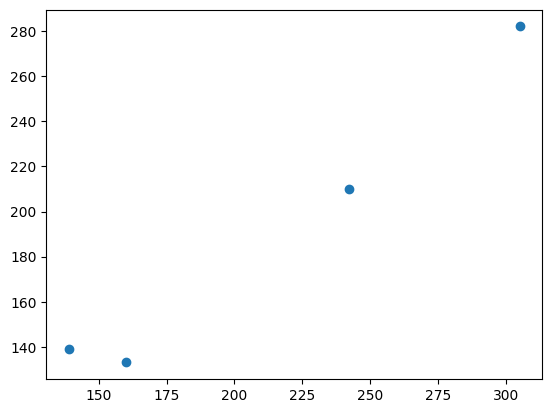

In [ ]:
#predict y_test
y_pred = model.predict(X_test)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='linear')  # Output layer with 1 unit and linear activation
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, epochs=500, batch_size=1, verbose=1, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/500
22/22 [==============================] - 1s 8ms/step - loss: 44578.1914 - mae: 200.6289 - val_loss: 32574.2012 - val_mae: 168.2077
Epoch 2/500
22/22 [==============================] - 0s 3ms/step - loss: 28562.9180 - mae: 157.5954 - val_loss: 16889.2402 - val_mae: 112.4699
Epoch 3/500
22/22 [==============================] - 0s 2ms/step - loss: 14028.3096 - mae: 107.6137 - val_loss: 6434.2446 - val_mae: 64.5904
Epoch 4/500
22/22 [==============================] - 0s 3ms/step - loss: 6372.1714 - mae: 69.1532 - val_loss: 4995.3423 - val_mae: 62.6108
Epoch 5/500
22/22 [==============================] - 0s 4ms/step - loss: 5041.7881 - mae: 57.8815 - val_loss: 5405.0093 - val_mae: 63.3128
Epoch 6/500
22/22 [==============================] - 0s 3ms/step - loss: 4986.6177 - mae: 57.3681 - val_loss: 5365.8838 - val_mae: 63.1263
Epoch 7/500
22/22 [==============================] - 0s 2ms/step - loss: 5039.2349 - mae: 57.4166 - val_loss: 5488.6738 - val_mae: 63.1971
Epoch 8/500
22/22

In [ ]:
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Training MAE: {train_mae}")

# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MAE: {test_mae}")

1/1 [==============================] - 0s 99ms/step - loss: 1963.4836 - mae: 37.3642
Training MAE: 37.36420822143555
1/1 [==============================] - 0s 35ms/step - loss: 902.7811 - mae: 25.0104
Test MAE: 25.010398864746094


In [ ]:
y_pred = model.predict(X_test)
y_pred

1/1 [==============================] - 0s 64ms/step


array([[222.03546],
       [188.09038],
       [162.79315],
       [276.80646]], dtype=float32)

In [ ]:
y_test

29    242
15    139
24    160
17    305
Name: total_runs_per_innings_match, dtype: int64